<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study2/blob/main/pR50_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow_model_optimization

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import time
import os
import tracemalloc
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import Model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 1.8 MB/s eta 0:00:00


In [3]:
# Define paths
train_dir = '/content/drive/MyDrive/motor_data/train'
validation_dir = '/content/drive/MyDrive/motor_data/validation'
test_dir = '/content/drive/MyDrive/motor_data/test'

# Set image size and batch size
image_size = (224, 224)
batch_size = 32

# Load datasets
train_dataset = image_dataset_from_directory(train_dir, image_size=image_size, batch_size=batch_size, label_mode='int')
validation_dataset = image_dataset_from_directory(validation_dir, image_size=image_size, batch_size=batch_size, label_mode='int')
test_dataset = image_dataset_from_directory(test_dir, image_size=image_size, batch_size=batch_size, label_mode='int')

# Input layer
inputs = Input(shape=(224, 224, 3))


Found 12004 files belonging to 4 classes.
Found 4000 files belonging to 4 classes.
Found 4004 files belonging to 4 classes.


In [4]:
# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)  # 4 classes: normal, fault_BB, fault_SM, fault_RI

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


94765736/94765736 [==============================] - 0s 0us/step


In [5]:
# Train the model
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[reduce_lr])

Epoch 1/10
376/376 [==============================] - 895s 2s/step - loss: 0.0141 - accuracy: 0.9961 - val_loss: 3.4571e-09 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 777s 2s/step - loss: 5.5725e-07 - accuracy: 1.0000 - val_loss: 3.8743e-10 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 785s 2s/step - loss: 1.2769e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 778s 2s/step - loss: 1.8196e-07 - accuracy: 1.0000 - val_loss: 2.9802e-11 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
376/376 [==============================] - 772s 2s/step - loss: 0.1287 - accuracy: 0.9841 - val_loss: 0.0268 - val_accuracy: 0.9960 - lr: 0.0010
Epoch 6/10
376/376 [==============================] - 774s 2s/step - loss: 0.0115 - accuracy: 0.9978 - val_loss: 0.0017 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 7/10
376/376 [================

In [6]:
# Initial evaluation
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Initial Validation Loss: {val_loss}")
print(f"Initial Validation Accuracy: {val_acc}")

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Initial Test Loss: {test_loss}")
print(f"Initial Test Accuracy: {test_acc}")

125/125 [==============================] - 63s 497ms/step - loss: 9.0924e-07 - accuracy: 1.0000
Initial Validation Loss: 9.092379968933528e-07
Initial Validation Accuracy: 1.0
126/126 [==============================] - 61s 467ms/step - loss: 2.2015e-05 - accuracy: 1.0000
Initial Test Loss: 2.2015252397977747e-05
Initial Test Accuracy: 1.0


In [7]:
# Save initial model and measure size
model.save('original_motor_fault_classification_model.h5')
original_model_size = os.path.getsize('original_motor_fault_classification_model.h5')
print(f"Original Model Size: {original_model_size / (1024 * 1024):.2f} MB")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Original Model Size: 282.47 MB


In [8]:
# Measure initial inference time and memory usage
start_time = time.time()
tracemalloc.start()
y_true, y_pred = [], []
for batch in test_dataset:
    images, labels = batch
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
original_inference_time = end_time - start_time
original_peak_memory = peak / (1024 * 1024)
print(f"Original Inference Time: {original_inference_time:.2f} seconds")
print(f"Original Peak Memory Usage: {original_peak_memory:.2f} MB")

1/1 [==============================] - 2s 2s/step
Original Inference Time: 82.16 seconds
Original Peak Memory Usage: 5.71 MB


In [9]:
# Initial model evaluation metrics
conf_matrix_original = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (Original):")
print(conf_matrix_original)

print("Classification Report (Original):")
print(classification_report(y_true, y_pred, target_names=['normal', 'fault_BB', 'fault_SM', 'fault_RI']))

Confusion Matrix (Original):
[[1004    0    0    0]
 [   0 1000    0    0]
 [   0    0 1000    0]
 [   0    0    0 1000]]
Classification Report (Original):
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1004
    fault_BB       1.00      1.00      1.00      1000
    fault_SM       1.00      1.00      1.00      1000
    fault_RI       1.00      1.00      1.00      1000

    accuracy                           1.00      4004
   macro avg       1.00      1.00      1.00      4004
weighted avg       1.00      1.00      1.00      4004



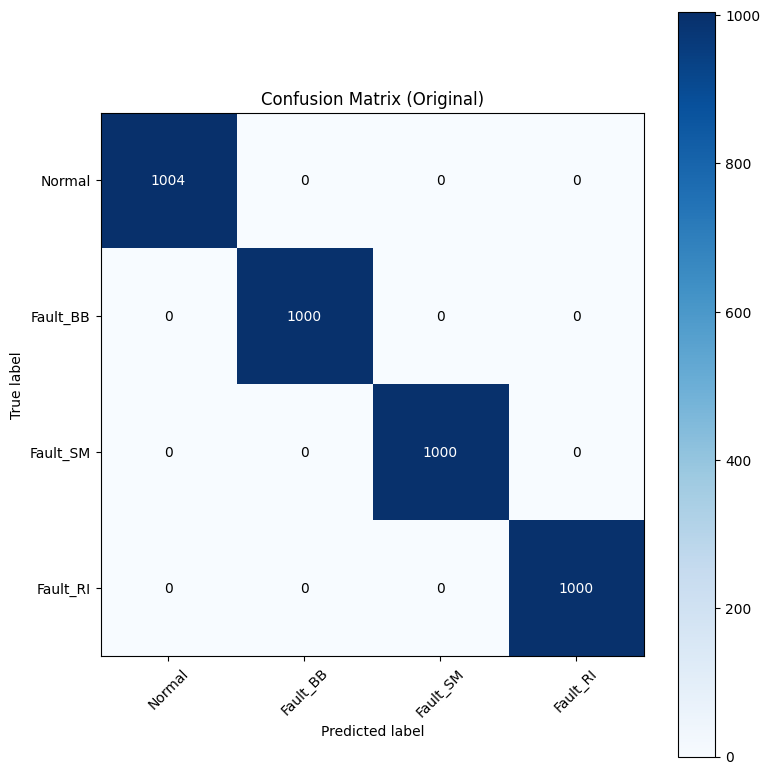

In [10]:
# Visualize initial confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix_original, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Original)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'])

fmt = 'd'
thresh = conf_matrix_original.max() / 2.
for i, j in np.ndindex(conf_matrix_original.shape):
    plt.text(j, i, format(conf_matrix_original[i, j], fmt),
             ha="center", va="center",
             color="white" if conf_matrix_original[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [11]:
# Calculate additional initial metrics
f1_original = f1_score(y_true, y_pred, average='weighted')
precision_original = precision_score(y_true, y_pred, average='weighted')
recall_original = recall_score(y_true, y_pred, average='weighted')

print(f"Original F1 Score: {f1_original:.2f}")
print(f"Original Precision: {precision_original:.2f}")
print(f"Original Recall: {recall_original:.2f}")

Original F1 Score: 1.00
Original Precision: 1.00
Original Recall: 1.00


In [12]:
# Structured Pruning 적용
def apply_structured_pruning(model, pruning_percentage=70):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            weights, biases = layer.get_weights()
            num_filters = weights.shape[-1]
            num_prune = int(num_filters * pruning_percentage / 100)

            # Compute the L1 norm of the filters
            filter_norms = np.sum(np.abs(weights), axis=(0, 1, 2))
            prune_indices = np.argsort(filter_norms)[:num_prune]

            # Set the weights of the pruned filters to zero
            for idx in prune_indices:
                weights[:, :, :, idx] = 0

            layer.set_weights([weights, biases])

apply_structured_pruning(model, pruning_percentage=70)

# Recompile pruned model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
  # Train pruned model
  history_pruned = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[reduce_lr])

Epoch 1/10
376/376 [==============================] - 820s 2s/step - loss: 0.1321 - accuracy: 0.9723 - val_loss: 661.1310 - val_accuracy: 0.3013 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 790s 2s/step - loss: 0.0107 - accuracy: 0.9990 - val_loss: 0.0014 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 788s 2s/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 8.9101e-04 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 789s 2s/step - loss: 7.1375e-05 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 0.9995 - lr: 0.0010
Epoch 5/10
376/376 [==============================] - 791s 2s/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.0010 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 6/10
376/376 [==============================] - 785s 2s/step - loss: 0.0612 - accuracy: 0.9939 - val_loss: 0.0016 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 7/10
376/376 [==============================] - 

In [ ]:
# Evaluate pruned model
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Pruned Validation Loss: {val_loss}")
print(f"Pruned Validation Accuracy: {val_acc}")

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Pruned Test Loss: {test_loss}")
print(f"Pruned Test Accuracy: {test_acc}")

In [ ]:
# Save pruned model
model_for_export = tfmot.sparsity.keras.strip_pruning(model)

In [ ]:
# Save the pruned model and measure size
model_for_export.save('pruned_motor_fault_classification_model.h5')
pruned_model_size = os.path.getsize('pruned_motor_fault_classification_model.h5')
print(f"Pruned Model Size: {pruned_model_size / (1024 * 1024):.2f} MB")

In [ ]:
# Measure pruned model inference time and memory usage
start_time = time.time()
tracemalloc.start()
y_true_pruned, y_pred_pruned = [], []
for batch in test_dataset:
    images, labels = batch
    y_true_pruned.extend(labels.numpy())
    predictions_pruned = model_for_export.predict(images)
    y_pred_pruned.extend(np.argmax(predictions_pruned, axis=1))
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
pruned_inference_time = end_time - start_time
pruned_peak_memory = peak / (1024 * 1024)
print(f"Pruned Inference Time: {pruned_inference_time:.2f} seconds")
print(f"Pruned Peak Memory Usage: {pruned_peak_memory:.2f} MB")

In [ ]:
# Pruned model evaluation metrics
conf_matrix_pruned = confusion_matrix(y_true_pruned, y_pred_pruned)
print("Confusion Matrix (Pruned):")
print(conf_matrix_pruned)

print("Classification Report (Pruned):")
print(classification_report(y_true_pruned, y_pred_pruned, target_names=['normal', 'fault_BB', 'fault_SM', 'fault_RI']))

In [ ]:
# Visualize pruned confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix_pruned, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Pruned)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'])

fmt = 'd'
thresh = conf_matrix_pruned.max() / 2.
for i, j in np.ndindex(conf_matrix_pruned.shape):
    plt.text(j, i, format(conf_matrix_pruned[i, j], fmt),
             ha="center", va="center",
             color="white" if conf_matrix_pruned[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate additional pruned metrics
f1_pruned = f1_score(y_true_pruned, y_pred_pruned, average='weighted')
precision_pruned = precision_score(y_true_pruned, y_pred_pruned, average='weighted')
recall_pruned = recall_score(y_true_pruned, y_pred_pruned, average='weighted')

print(f"Pruned F1 Score: {f1_pruned:.2f}")
print(f"Pruned Precision: {precision_pruned:.2f}")
print(f"Pruned Recall: {recall_pruned:.2f}")

In [ ]:
# 양자화 인식 훈련을 위해 모델을 다시 정의
quantize_model = tfmot.quantization.keras.quantize_model

# PTQ 양자화 적용
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_gen():
    for images, labels in test_dataset.take(100):
        for i in range(images.shape[0]):
            yield [tf.expand_dims(images[i], 0)]

converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()


In [ ]:
# Save the quantized model
with open('quantized_motor_fault_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)

quantized_model_size = os.path.getsize('quantized_motor_fault_classification_model.tflite')
print(f"Quantized Model Size: {quantized_model_size / (1024 * 1024):.2f} MB")

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='quantized_motor_fault_classification_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Test the model on test dataset
start_time = time.time()
tracemalloc.start()
y_true_quant, y_pred_quant = [], []

for batch in test_dataset:
    images, labels = batch
    y_true_quant.extend(labels.numpy())
    for i in range(images.shape[0]):
        interpreter.set_tensor(input_details[0]['index'], [images[i].numpy()])
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        y_pred_quant.append(np.argmax(output_data))

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
quantized_inference_time = end_time - start_time
quantized_peak_memory = peak / (1024 * 1024)
print(f"Quantized Inference Time: {quantized_inference_time:.2f} seconds")
print(f"Quantized Peak Memory Usage: {quantized_peak_memory:.2f} MB")


In [ ]:
# Quantized model evaluation metrics
conf_matrix_quant = confusion_matrix(y_true_quant, y_pred_quant)
print("Confusion Matrix (Quantized):")
print(conf_matrix_quant)

print("Classification Report (Quantized):")
print(classification_report(y_true_quant, y_pred_quant, target_names=['normal', 'fault_BB', 'fault_SM', 'fault_RI']))


In [ ]:
# Visualize quantized confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix_quant, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Quantized)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'])

fmt = 'd'
thresh = conf_matrix_quant.max() / 2.
for i, j in np.ndindex(conf_matrix_quant.shape):
    plt.text(j, i, format(conf_matrix_quant[i, j], fmt),
             ha="center", va="center",
             color="white" if conf_matrix_quant[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
# 추가 양자화 모델 메트릭 계산
f1_quant = f1_score(y_true_quant, y_pred_quant, average='weighted')
precision_quant = precision_score(y_true_quant, y_pred_quant, average='weighted')
recall_quant = recall_score(y_true_quant, y_pred_quant, average='weighted')

print(f"Quantized F1 Score: {f1_quant:.2f}")
print(f"Quantized Precision: {precision_quant:.2f}")
print(f"Quantized Recall: {recall_quant:.2f}")

In [ ]:
# 최종 결과 요약 및 비교
print(f"\nSummary of Results:")
print(f"Original Model Size: {original_model_size / (1024 * 1024):.2f} MB")
print(f"Pruned Model Size: {pruned_model_size / (1024 * 1024):.2f} MB")
print(f"Quantized Model Size: {quantized_model_size / (1024 * 1024):.2f} MB")

print(f"Original Inference Time: {original_inference_time:.2f} seconds")
print(f"Pruned Inference Time: {pruned_inference_time:.2f} seconds")
print(f"Quantized Inference Time: {quantized_inference_time:.2f} seconds")

print(f"Original Peak Memory Usage: {original_peak_memory:.2f} MB")
print(f"Pruned Peak Memory Usage: {pruned_peak_memory:.2f} MB")
print(f"Quantized Peak Memory Usage: {quantized_peak_memory:.2f} MB")

print(f"Original F1 Score: {f1_original:.2f}")
print(f"Pruned F1 Score: {f1_pruned:.2f}")
print(f"Quantized F1 Score: {f1_quant:.2f}")

print(f"Original Precision: {precision_original:.2f}")
print(f"Pruned Precision: {precision_pruned:.2f}")
print(f"Quantized Precision: {precision_quant:.2f}")

print(f"Original Recall: {recall_original:.2f}")
print(f"Pruned Recall: {recall_pruned:.2f}")
print(f"Quantized Recall: {recall_quant:.2f}")